In [2]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
import cmocean
import rasterio
from rasterio.plot import show

In [3]:
path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
ncdf_src = 'BedMachineAntarctica_2020-07-15_v02.nc'

ds = gdal.Open(path+ncdf_src)

for item in ds.GetSubDatasets():
    print (item[0])

HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://bed
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://errbed
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://firn
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://geoid
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://mask
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://source
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://surface
HDF5:"D:\3_DataViz\2_glaciers\0_Antartica\BedMachineAntarctica_2020-07-15_v02.nc"://thickness


In [49]:
# Option 1
#thickness = gdal.Open('NETCDF:"/Users/kdruken/Downloads/LS8_OLI_TIRS_NBAR_3577_-10_-28_2013.nc":band_2')

# Option 2 :
#   ds.GetSubDatasets()[7][0] = thickness
src = gdal.Open(ds.GetSubDatasets()[7][0])

print (src.GetMetadata())
print(type(src))


{'Author': 'Mathieu Morlighem', 'Conventions': 'CF-1.7', 'Data_citation': 'Morlighem M. et al., (2019), Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience (accepted)', 'ice_density_(kg_m-3)': '917 ', 'license': 'No restrictions on access or use', 'Notes': 'Data processed at the Department of Earth System Science, University of California, Irvine', 'no_data': '-9999 ', 'nx': '13333 ', 'ny': '13333 ', 'proj4': '+init=epsg:3031', 'Projection': 'Polar Stereographic South (71S,0E)', 'sea_water_density_(kg_m-3)': '1027 ', 'spacing': '500 ', 'Title': 'BedMachine Antarctica', 'version': '15-Jul-2020 (v2.0)', 'xmin': '-3333000 ', 'ymax': '3333000 ', '_nc3_strict': '1 '}
<class 'osgeo.gdal.Dataset'>


In [59]:
# Note GetRasterBand() takes band no. starting from 1 not 0
band = src.GetRasterBand(1)
# set nodata = 0 
band.SetNoDataValue(0)
nodata = band.GetNoDataValue()
arr = band.ReadAsArray()
#Create a masked array for making calculations without nodata values
arr = np.ma.masked_equal(arr, nodata)


In [60]:
 (arr.min(), arr.max(), arr.mean(), arr.std())
#np.sum(np.array(arr) <= 0)

(1.4e-43, 4726.5464, 1931.4324082389624, 1059.706145084085)

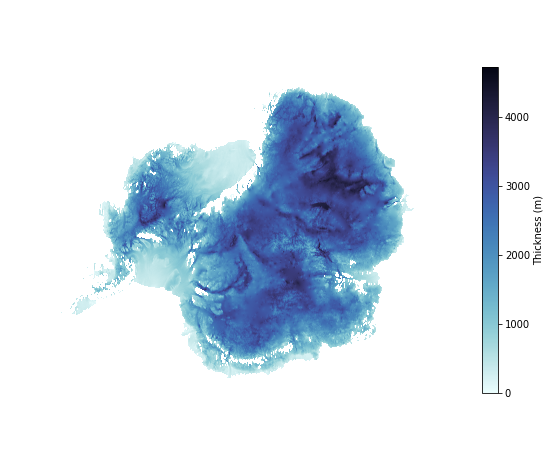

In [61]:
plt.figure(figsize=(10,12))
fig = plt.imshow(arr, origin='lower', cmap=cmocean.cm.ice_r)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#tickval = [1, 10, 100, 100, 500]
#t = np.log(tickval)
cb = plt.colorbar(fig, shrink=0.5)
cb.set_label('Thickness (m)')
#cb.ax.set_yticklabels(tickval)
plt.show()

In [62]:
#normalization du np.array between [0 to 1]
norm_arr =  arr - arr.min() 
norm_arr /= arr.max()-arr.min()


In [63]:
# apply the colormap to dataset
cmap=cmocean.cm.ice_r
rgb_ds = cmap(norm_arr)
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
#Round to the nearest bigger integer
data_array_scaled = np.ceil(data_array_scaled)
data_array_scaled = data_array_scaled.astype(int)
print(data_array_scaled.shape)

(13333, 13333, 4)


In [64]:
 (data_array_scaled.min(), data_array_scaled.max(), data_array_scaled.mean(), data_array_scaled.std())

(0, 255, 52.85429128715543, 88.97499206843233)

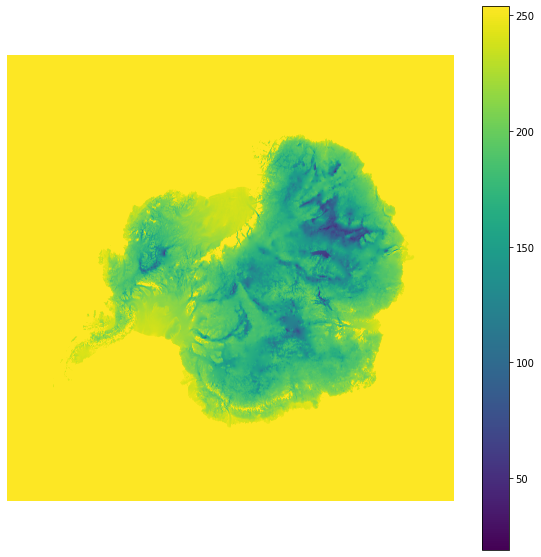

In [12]:
plt.figure(figsize=(10,10))
fig = plt.imshow(data_array_scaled[:,:,2], origin='lower')
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

SetGeoTransform

with (your_top_left_x, pixelWidth, 0, your_top_left_y, 0, -pixelHeight)

Bedmachine Antartica:
    Longitude of true origin: 0°E
    Latitude of true origin : 71°S

https://www.pgc.umn.edu/apps/convert/

y: 3333000

x: -3333000



In [65]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
out_path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
dest_name = out_path + 'Antarctica_2020-07-15_v02_thickness.tif'

# info from source
originX = -3333000
originY = 3333000 
pixelWidth = int(src.GetMetadata()['spacing'])
pixelHeight = int(src.GetMetadata()['spacing'])
bands = data_array_scaled.shape[2]-1
rows = src.RasterXSize
cols = src.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, -pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(255)


#reprojection (source : http://www2.geog.ucl.ac.uk/~plewis/geogg122_local/geogg122-old/Chapter4_GDAL/GDAL_Python_bindings.html)
proj4_bedmachine = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

destSRS = osr.SpatialReference()
destSRS.ImportFromProj4 (proj4_bedmachine)
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None


reproject : https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon


In [67]:
# add an alpha band to the RGB for transparent background in Mapbox
src_file = path + 'Antarctica_2020-07-15_v02_thickness.tif'
dest_file = path + 'Antarctica_2020-07-15_v02_thickness_rgba.tif'

options = gdal.WarpOptions(format='GTiff', srcNodata=0, dstAlpha=True)
dest = gdal.Warp(dest_file, src_file, options=options)
dest = None

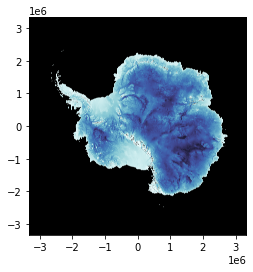

<AxesSubplot:>

In [68]:
fp = path + 'Antarctica_2020-07-15_v02_thickness_rgba.tif'
img = rasterio.open(fp)
show(img)

# reprojection

In [75]:
    ds = path + 'Antarctica_2020-07-15_v02_thickness.tif'
    out_file = path + 'Antarctica_2020-07-15_v02_thickness_3857.tif'
    warp_options = gdal.WarpOptions(dstSRS = 'EPSG:3857')
    gdal.Warp(destNameOrDestDS = out_file, srcDSOrSrcDSTab = ds, options = warp_options)
    print("Processing done for "+out_file)
    ds = None

Processing done for D:\3_DataViz\2_glaciers\0_Antartica\Antarctica_2020-07-15_v02_thickness_3857.tif
